# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner 


<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'


<hr style="height:2pt">

<div class='exercise'><b> Question 1 [50 pts]: Modeling seasonality of Airbnb prices </b></div>

In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

**1.1** Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`


**1.2** Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.


**1.3** Explore different regression models. Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method. Make sure to fit your model on *all training set observations*. Do not average or otherwise combine the data before fitting.


*Important*: Convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

* **1.3.1** Fit simple polynomial models of degree 2, 3, 5, and 8 via the `statsmodels` library to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

* **1.3.2** You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

* **1.3.3** Fit a penalized B-spline using `pygam` with the smoothness parameter chosen by cross-validation on the training set.  Again, provide the train and test scores of the best-performing model and plot its predictions.

* **1.3.4** Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?


**1.4** It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit. Create a binary indicator of weekend versus non-weekend, and include it in your additive model based on `pygam`.  How does it impact the model's performance?  

*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


**1.5** You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices. Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?


**1.1** Start by loading the data using pandas.
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`



In [5]:
# your code here
training_data = pd.read_csv('data/calendar_train.csv', parse_dates= [1])
testing_data = pd.read_csv('data/calendar_test.csv', parse_dates=[1])

In [6]:
training_data.head()

,listing_id,date,available,price
0,20872145,2018-09-21,f,NaN
1,20872145,2018-09-19,f,NaN
2,20872145,2018-09-18,f,NaN
3,20872145,2018-09-17,f,NaN
4,20872145,2018-09-16,f,NaN


In [7]:
training_data['price'].isna().mean()

0.57862842522442

In [8]:
testing_data['price'].isna().mean()

0.5768854189184034

Therefore, we can see that both for training and testing, a lot of the data for price is missing (which is our target variable). For now, let's drop them into separate training and testing frames.

In [9]:
training_data_complete = training_data.dropna()
testing_data_complete = testing_data.dropna()

**1.2** Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.



In [10]:
# your code here
training_data_complete['month'] = training_data_complete['date'].apply(lambda x: pd.Timestamp.month_name(x))
testing_data_complete['month'] = testing_data_complete['date'].apply(lambda x: pd.Timestamp.month_name(x))
training_data_complete['day_of_week'] = training_data_complete['date'].apply(lambda x: pd.Timestamp.day_name(x))
testing_data_complete['day_of_week'] = testing_data_complete['date'].apply(lambda x: pd.Timestamp.day_name(x))

In [11]:
training_data_complete.head()

,listing_id,date,available,price,month,day_of_week
123,20872145,2018-04-02,t,62.0,April,Monday
124,20872145,2018-04-01,t,59.0,April,Sunday
125,20872145,2018-03-31,t,75.0,March,Saturday
126,20872145,2018-03-30,t,71.0,March,Friday
127,20872145,2018-03-28,t,51.0,March,Wednesday


In [12]:
monthly_data = training_data_complete.groupby(by='month').mean()['price']
daily_data = training_data_complete.groupby(by='day_of_week').mean()['price']

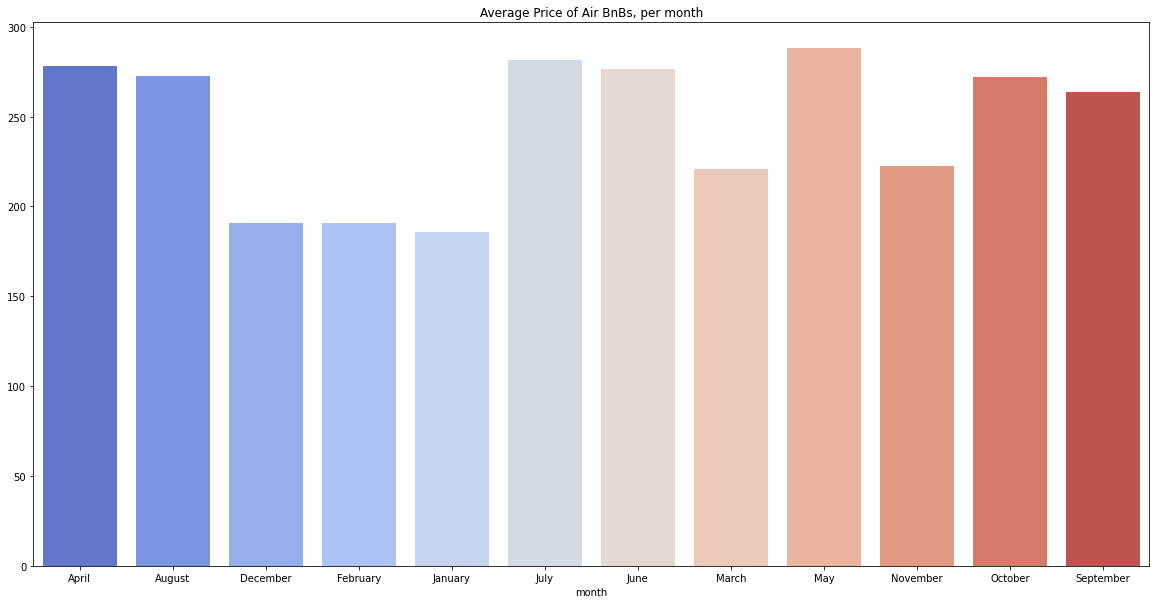

In [13]:
fig, ax = plt.subplots(1, figsize = (20, 10))
sns.barplot(x=monthly_data.index, y=monthly_data.values, ax=ax, palette='coolwarm')
plt.title('Average Price of Air BnBs, per month')
plt.show(fig)

Regarding the monthly trends, I was expecting hot weather months to be more expensive than cold weather months. This is being corroborated by this bar plot, where we can see significant difference in prices for months November - March (cold weather) and April - October (hot weather).

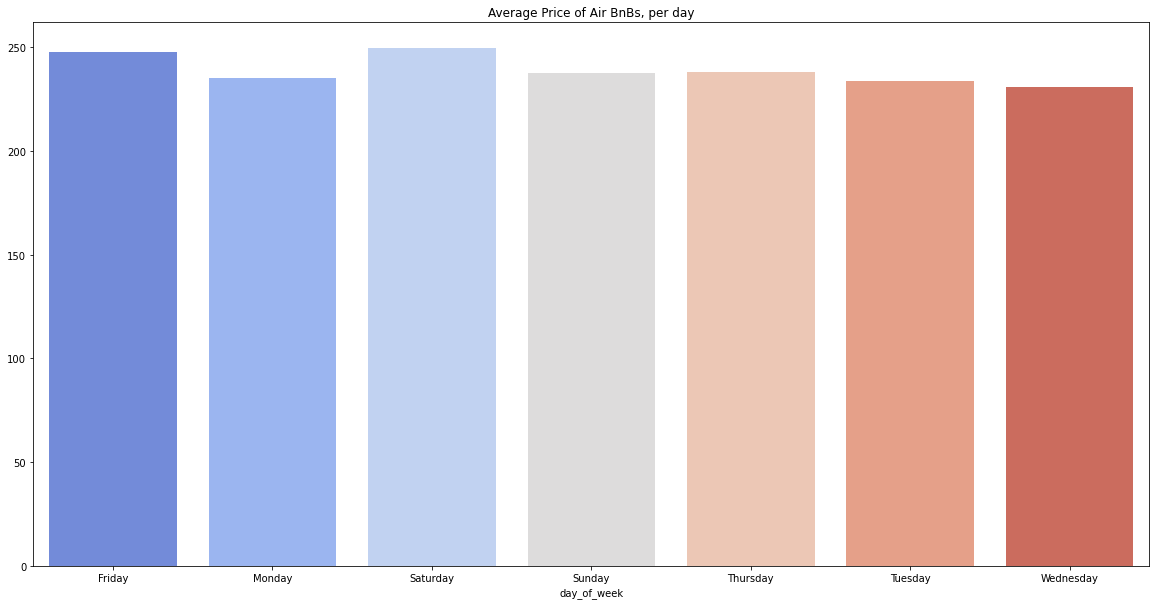

In [14]:
fig, ax = plt.subplots(1, figsize=(20, 10))
sns.barplot(x=daily_data.index, y=daily_data.values, ax=ax, palette='coolwarm')
plt.title('Average Price of Air BnBs, per day')
plt.show(fig)

Regarding the daily trends, I was expecting the week-end to be more expensive. 

From the barplot above, we can see that renting the Friday night and Saturday night are slightly more expensive than the rest of the week, but not significantly. We might want to explore statistical testing models in order to confirm this trend.

**1.3** Explore different regression models. Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method. Make sure to fit your model on *all training set observations*. Do not average or otherwise combine the data before fitting.


*Important*: Convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

**1.3.1** Fit simple polynomial models of degree 2, 3, 5, and 8 via the `statsmodels` library to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.



In [15]:
# your code here
predictor_date_train = training_data_complete['date'] - training_data_complete['date'].min()
predictor_date_train = predictor_date_train.apply(lambda x: x.days).values
training_data_complete['predictor_date'] = predictor_date_train
predictor_date_test = testing_data_complete['date'] - testing_data_complete['date'].min()
predictor_date_test = predictor_date_test.apply(lambda x: x.days).values
testing_data_complete['predictor_date'] = predictor_date_test

In [16]:
training_data_complete.head(5)

,listing_id,date,available,price,month,day_of_week,predictor_date
123,20872145,2018-04-02,t,62.0,April,Monday,178
124,20872145,2018-04-01,t,59.0,April,Sunday,177
125,20872145,2018-03-31,t,75.0,March,Saturday,176
126,20872145,2018-03-30,t,71.0,March,Friday,175
127,20872145,2018-03-28,t,51.0,March,Wednesday,173


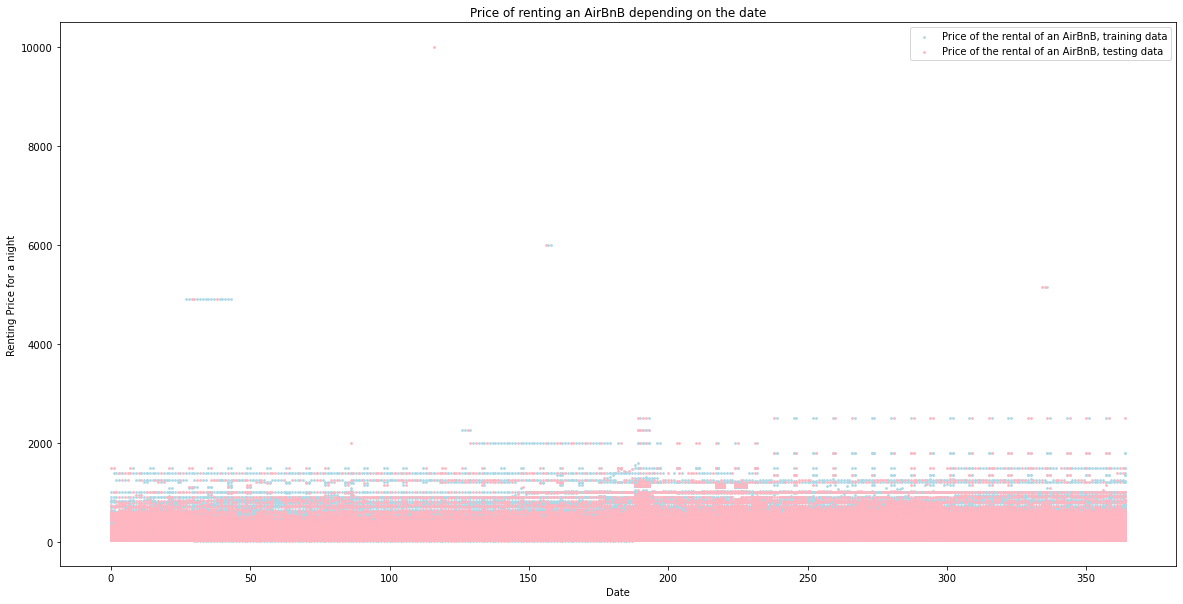

In [17]:
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.scatter(training_data_complete['predictor_date'], training_data_complete['price'], label='Price of the rental of an AirBnB, training data', s=3, color='lightblue')
ax.scatter(testing_data_complete['predictor_date'], testing_data_complete['price'], label='Price of the rental of an AirBnB, testing data', s=3, color='lightpink')
plt.title('Price of renting an AirBnB depending on the date')
ax.set_xlabel('Date')
ax.set_ylabel('Renting Price for a night')
ax.legend()
plt.show(fig)

Therefore, as we can see, the training and testing distributions are fairly similar: there should be no great issue with the generalization properties of our model. **However**, there is going to be an issue with fitting our training sample. Indeed, no obvious linear (or polynomial, or of any kind) relationship can be distinguished from the above scatterplot. Therefore, I expect difficulties when trying to predict prices *solely based on the numeric predictor we defined for date*. One more clever way to fit a model would indeed be to aggregate the training and testing data **per date**. Indeed, since the end-objective of our model is to predict the price of an AirBnB given a day, the training set should reflect this pattern.  

#### Fitting different global polynomial regression models to the data, leveraging statsmodel

In [18]:
formula_d2 = "price ~ np.vander(predictor_date, 3, increasing=True)-1" # degree 2
fit2_lm = sm.ols(formula_d2, data = training_data_complete).fit()
formula_d3 = "price ~ np.vander(predictor_date, 4, increasing=True)-1" # degree 3
fit3_lm = sm.ols(formula_d3, data = training_data_complete).fit()
formula_d5 = "price ~ np.vander(predictor_date, 6, increasing=True)-1" # degree 5
fit5_lm = sm.ols(formula_d5, data = training_data_complete).fit()
formula_d8 = "price ~ np.vander(predictor_date, 9, increasing=True)-1" # degree 8
fit8_lm = sm.ols(formula_d8, data = training_data_complete).fit()

#### Performances of our fit 

##### R2 on the training set

In [19]:
training_feature = training_data_complete['predictor_date']
training_labels = training_data_complete['price'].values
poly_predictions_2 = fit2_lm.get_prediction(training_feature).summary_frame()['mean']
poly_predictions_3 = fit3_lm.get_prediction(training_feature).summary_frame()['mean']
poly_predictions_5 = fit5_lm.get_prediction(training_feature).summary_frame()['mean']
poly_predictions_8 = fit8_lm.get_prediction(training_feature).summary_frame()['mean']
training_predictions = [poly_predictions_2, poly_predictions_3, poly_predictions_5, poly_predictions_8]

In [20]:
r2_train_score = [np.round(r2_score(training_labels, prediction), 3) for prediction in  training_predictions]
r2_train_score

[0.018, 0.039, 0.042, -0.17]

As we predicted, we can see that we have a poor fit on the training set. Let visualize the functions that have been created by these fits. 

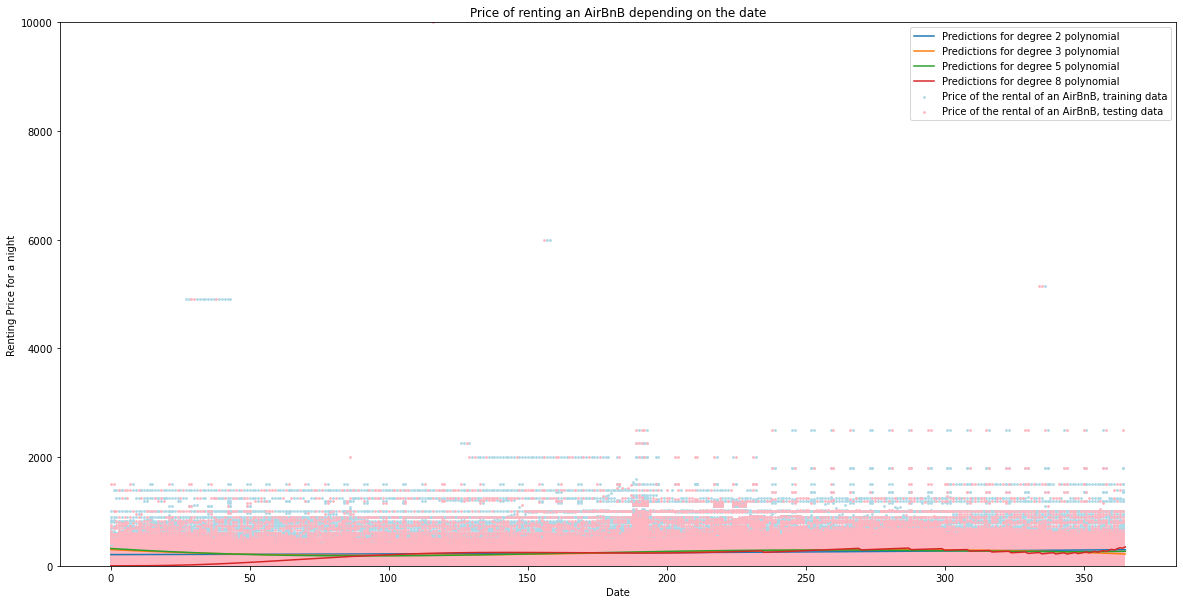

In [21]:
days = np.arange(0, 366)
predict_df = pd.DataFrame({'predictor_date': days})
artificial_pred2 = fit2_lm.get_prediction(predict_df).summary_frame()['mean']
artificial_pred3 = fit3_lm.get_prediction(predict_df).summary_frame()['mean']
artificial_pred5 = fit5_lm.get_prediction(predict_df).summary_frame()['mean']
artificial_pred8 = fit8_lm.get_prediction(predict_df).summary_frame()['mean']
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.scatter(training_data_complete['predictor_date'], training_data_complete['price'], label='Price of the rental of an AirBnB, training data', s=3, color='lightblue')
ax.scatter(testing_data_complete['predictor_date'], testing_data_complete['price'], label='Price of the rental of an AirBnB, testing data', s=3, color='lightpink')
ax.plot(days, artificial_pred2, label='Predictions for degree 2 polynomial')
ax.plot(days, artificial_pred3, label='Predictions for degree 3 polynomial')
ax.plot(days, artificial_pred5, label='Predictions for degree 5 polynomial')
ax.plot(days, artificial_pred8, label='Predictions for degree 8 polynomial')
ax.set_ylim(0, 10000)
plt.title('Price of renting an AirBnB depending on the date')
ax.set_xlabel('Date')
ax.set_ylabel('Renting Price for a night')
ax.legend()
plt.show(fig)

This explains why we have such a poor fit: both degree 2 and 3 polynomials seem like they are only predicting the average price, whereas degree 5 and 8 polynomials have an unexpected behavior due to their large degrees. 

In [22]:
df = pd.DataFrame({'Degree 2': np.append(fit2_lm.params.values, np.zeros(6)), 'Degree 3': np.append(fit3_lm.params.values, np.zeros(5)), 'Degree 5': np.append(fit5_lm.params.values, np.zeros(3)), 'Degree 8': fit8_lm.params.values}, index=['$b_0$', '$b_1$','$b_2$','$b_3$','$b_4$','$b_5$','$b_6$','$b_7$','$b_8$'])
df

,Degree 2,Degree 3,Degree 5,Degree 8
$b_0$,206.093239,297.346254,3.180890e+02,6.821044e-09
$b_1$,0.079469,-2.543320,-3.059293e+00,7.850599e-07
$b_2$,0.000463,0.017967,1.546802e-02,2.781495e-05
$b_3$,0.000000,-0.000032,5.116189e-05,1.084522e-03
$b_4$,0.000000,0.000000,-4.095473e-07,-1.522053e-05
$b_5$,0.000000,0.000000,5.842773e-10,8.210779e-08
$b_6$,0.000000,0.000000,0.000000e+00,-1.972745e-10
$b_7$,0.000000,0.000000,0.000000e+00,1.764656e-13
$b_8$,0.000000,0.000000,0.000000e+00,1.620903e-18


Therefore, it is well corroborated that in the models, the significant terms are the low-degree terms. We can also see that the reason why the movement becomes uncontrollable for the degree 8 is that: $350^7*1.7*10^{-17} \approx 113000$.

##### R2 on the testing set

In [23]:
testing_feature = testing_data_complete['predictor_date']
testing_labels = testing_data_complete['price']
poly_predictions_2 = fit2_lm.get_prediction(testing_feature).summary_frame()['mean']
poly_predictions_3 = fit3_lm.get_prediction(testing_feature).summary_frame()['mean']
poly_predictions_5 = fit5_lm.get_prediction(testing_feature).summary_frame()['mean']
poly_predictions_8 = fit8_lm.get_prediction(testing_feature).summary_frame()['mean']

In [24]:
r2_test_score = [np.round(r2_score(testing_labels, prediction), 3) for prediction in  [poly_predictions_2, poly_predictions_3, poly_predictions_5, poly_predictions_8]]
r2_test_score

[0.019, 0.039, 0.042, -0.158]

We can see that the same behavior occurs in the testing set: this was expected since both training and testing sets have the same distribution. 

Now that we have observed the behavior of our predictions against **all** of the training and testing data, let us see if our models capture well the **average** daily price in the training data (which I expect it should for low degrees, since **all** observations have the same weight in linear regression). 

In [25]:
training_data_complete.groupby('predictor_date').mean()

,listing_id,price
predictor_date,,
0,1.322575e+07,370.173410
1,1.258238e+07,409.298701
2,1.217451e+07,299.128713
3,1.232258e+07,282.768908
4,1.227489e+07,275.933202
...,...,...
360,1.039771e+07,239.277273
361,1.060764e+07,231.923318
362,1.063275e+07,236.257967


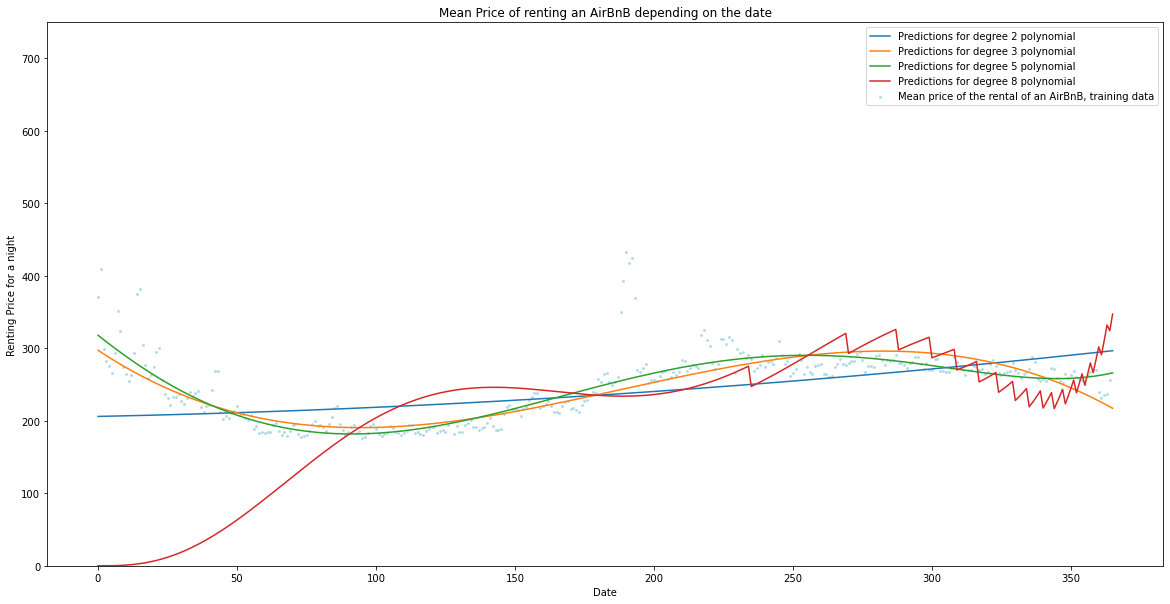

In [26]:
days = np.arange(0, 366)
predict_df = pd.DataFrame({'predictor_date': days})
artificial_pred2 = fit2_lm.get_prediction(predict_df).summary_frame()['mean']
artificial_pred3 = fit3_lm.get_prediction(predict_df).summary_frame()['mean']
artificial_pred5 = fit5_lm.get_prediction(predict_df).summary_frame()['mean']
artificial_pred8 = fit8_lm.get_prediction(predict_df).summary_frame()['mean']
aggregated_data = training_data_complete.groupby('predictor_date').mean()
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.scatter(aggregated_data.index.values, aggregated_data['price'].values, label='Mean price of the rental of an AirBnB, training data', s=3, color='lightblue')
ax.plot(days, artificial_pred2, label='Predictions for degree 2 polynomial')
ax.plot(days, artificial_pred3, label='Predictions for degree 3 polynomial')
ax.plot(days, artificial_pred5, label='Predictions for degree 5 polynomial')
ax.plot(days, artificial_pred8, label='Predictions for degree 8 polynomial')
ax.set_ylim(0, 750)
plt.title('Mean Price of renting an AirBnB depending on the date')
ax.set_xlabel('Date')
ax.set_ylabel('Renting Price for a night')
ax.legend()
plt.show(fig)

We can see that the fit of our models of degree 2 and 3 are way better when comparing to the mean price per day, as expected. However, the high degree polynomials keep on behaving in an anarchic way, which was also expected.

**1.3.2** You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?


In [27]:
np.linalg.cond(np.vander(training_data_complete['predictor_date'], 9, increasing=True))

1.974424125230613e+19

In [28]:
np.linalg.matrix_rank(np.vander(training_data_complete['predictor_date'], 9, increasing=True))

4

Several things are going wrong with this model:
- Runge's phemonenon: ill-conditioning of the Vandermonde matrix of degree 8. This leads to numerical instability: the coefficients are very sensitive to small variations in the data (this is directly related to the conditioning number of the Vandermonde matrix). We can see here that the conditioning number of the Vandermonde matrix is $O(10^{19})$.
- The coefficients of the model for high degrees are not completely zero. This leads to the fact that we are going to have very large variations for large input values. As we said, for degree 8 $\quad 350^7∗1.7∗10^{−17}≈113000$.

In order to deal with the problem of ill-conditioning, we could leverage orthogonal polynomials, but this won't solve the problem of having non-zero (although very small) coefficients for large degree values. 

Therefore, in order to understand how to apprehend this problem, we should ask ourselves the question of why we would want in the first place to leverage such high-degree polynomial. The problem when dealing with Linear Regression is *flexibility* of our model: we impose a linear relationship between X and $\mathbb{E}[Y|X]$. Dealing with larger order polynomials allow us to reduce this flexibility, and allow for more basis functions to be considered when approaching our target function. However, we have seen that allowing **too much** flexibility **globally** might come with additional issues we have not foreseen (due, in part to the ill-conditioning of the problem). 

Therefore, one way to allow for more flexibility is to enhance our function basis with additional polynomial functions, but to approach them **locally**, meaning that we are going to use less flexible functions (cubic functions) that have a local impact on the target function: this is what happens with penalized B-splines, being a generalization of cubic splines but leveraging Bessel functions that have significant importance in a local area. Therefore, what we are doing right here is **adding flexibility** that is not encoded in the degree of our polynomial, but rather in the number of knots for the penalized B-spline we are fitting for our *univariate* data (formultivariate data, we don't know how to fit those univariate splines, we use GAM).

**1.3.3** Fit a penalized B-spline using `pygam` with the smoothness parameter chosen by cross-validation on the training set.  Again, provide the train and test scores of the best-performing model and plot its predictions.


#### Without Cross Validation for the smoothness parameter

In [29]:
# your code here
gam = LinearGAM(s(0))  # by default, the spline fitted is a penalized B - spline, with lambda = 0.6
X, y = training_data_complete['predictor_date'], training_data_complete['price']
gam.fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.7388
Link Function:                     IdentityLink Log Likelihood:                              -3510882.8282
Number of Samples:                       309288 AIC:                                           7021807.134
                                                AICc:                                         7021807.1369
                                                GCV:                                            33950.6043
                                                Scale:                                          33946.7042
                                                Pseudo R-Squared:                                    0.045
Feature Function                  Lam

<ipython-input-29-3ca7cde2e652>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Here, we can see that the default smoothing parameter has been set to $\lambda = 0.6$. The resulting $R^2 = 0.045$ is better than any of our previous fits in terms of **training $R^2$**. Moreover, we have access to the **GCV = Generalization Cross Validation Error**.

#### With Cross-Validation on the smoothing parameter

In [30]:
lams = np.logspace(-3, 5, 9)
best_r2 = 0
best_lam = 0
for lam in lams:
    gam = LinearGAM(s(0), lam=lam)
    kf = KFold(n_splits=5)
    kf.get_n_splits(X.values)
    r2_scores = []
    for train_index, test_index in kf.split(X.values):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        gam.fit(X_train, y_train)
        r2_scores.append(r2_score(y_test, gam.predict(X_test))) 
        if np.mean(r2_scores) > best_r2:
            best_r2 = np.mean(r2_scores)
            best_lam = lam
gam = LinearGAM(s(0), lam=best_lam)
gam.fit(X, y).summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                        20.0
Link Function:                     IdentityLink Log Likelihood:                              -3510882.8876
Number of Samples:                       309288 AIC:                                          7021807.7752
                                                AICc:                                         7021807.7782
                                                GCV:                                            33950.6624
                                                Scale:                                          33946.7107
                                                Pseudo R-Squared:                                    0.045
Feature Function                  Lam

<ipython-input-30-bd8c1f62fd46>:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.fit(X, y).summary()


We can see that, after having performed Cross Validation based on the smoothing parameter, we get similar results in terms of performances on the training set: $R^2_{train} = 0.045$. Let us now explore the *test* performances of this model. 

In [31]:
test_r2 = r2_score(testing_data_complete['price'], gam.predict(testing_data_complete['predictor_date']))
test_r2

0.044802610441945

We can therefore see that this model, with penalized B-splines perform better than the other polynomial models in terms of explaining the variance contained in the test data.

#### Visualizing the predictions of the B-splines-model

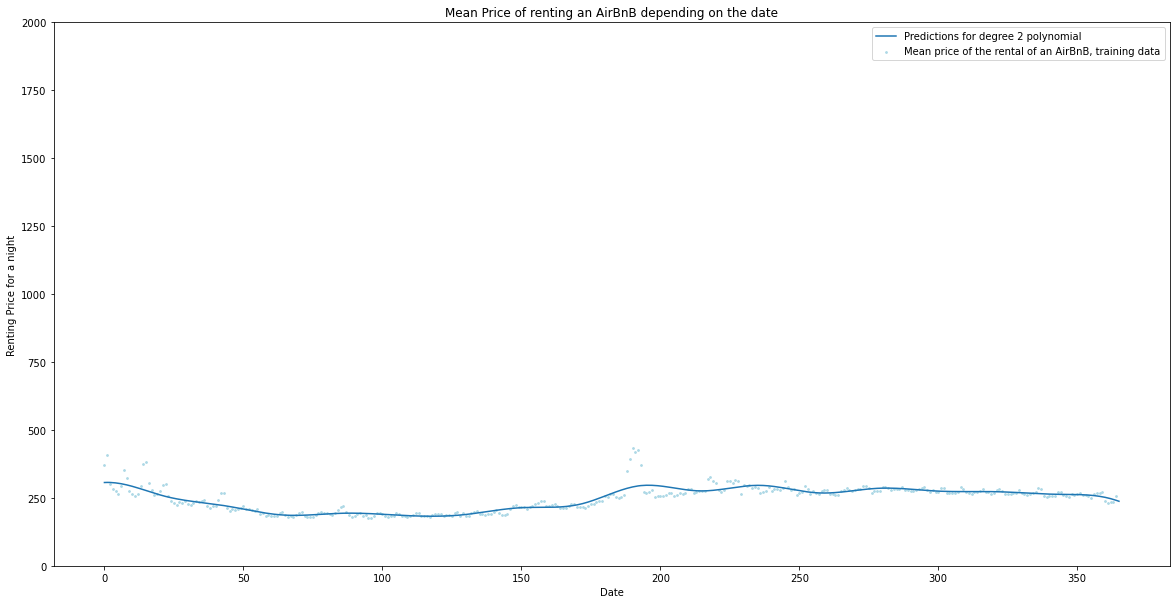

In [32]:
days = np.arange(0, 366)
artificial_pred = gam.predict(days)
aggregated_data = training_data_complete.groupby('predictor_date').mean()
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.scatter(aggregated_data.index.values, aggregated_data['price'].values, label='Mean price of the rental of an AirBnB, training data', s=3, color='lightblue')
ax.plot(days, artificial_pred, label='Predictions for degree 2 polynomial')
ax.set_ylim(0, 2000)
plt.title('Mean Price of renting an AirBnB depending on the date')
ax.set_xlabel('Date')
ax.set_ylabel('Renting Price for a night')
ax.legend()
plt.show(fig)

**1.3.4** Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?


It depends on the metrics we would like to use in order to discriminate between models:
- **$R^2$ on the entire set**: whether we use training or testing $R^2$, the best models are going to be the penalized B splines
- **$R^2$ on the aggregated testing set**: From the visualization we have made earlier, we can see that only degree 3 and penalized B-splines models seem to fit in the right way the aggregated train/test set. Let us see how well this models explain the variability of the *aggregated* test set.

THe effect of tuning parameters is:
- for the degree of the different polynomials that are fitted, it is crucial to select the appropriate degree of polynomials in order not to get uncoherent results for extreme values of X. 
- For the penalized B-spline, the effect of the smoothness penalty is to limit the wiggliness of the resulting B-spline function. We should select it carefully, as an over-penalized model would result in a global cubic polynomial regression.

In [33]:
aggregated_test_data = testing_data_complete.groupby('predictor_date').mean()
X, y = aggregated_test_data.index, aggregated_test_data['price']

In [34]:
r2_pygam = r2_score(y, gam.predict(X))
print(r2_pygam)

0.7480592043266275


**We can see that the pygam model performs relatively well in explaining the variance in the aggregated test set.**

**1.4** It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit. Create a binary indicator of weekend versus non-weekend, and include it in your additive model based on `pygam`.  How does it impact the model's performance?

*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.



In [35]:
# your code here
training_data_complete['week-end'] = 1*(training_data_complete['day_of_week'] == 'Friday') + 1*(training_data_complete['day_of_week'] == 'Saturday')
testing_data_complete['week-end'] = 1*(testing_data_complete['day_of_week'] == 'Friday') + 1*(testing_data_complete['day_of_week'] == 'Saturday')
X, y = training_data_complete[['predictor_date', 'week-end']].values, training_data_complete['price'].values
gam = LinearGAM(s(0) + f(1))
lams = np.random.rand(100, 2) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3
gam.gridsearch(X, y, lam=lams)
gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:10:00 Time:  0:10:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.6159
Link Function:                     IdentityLink Log Likelihood:                              -3510509.8699
Number of Samples:                       309288 AIC:                                          7021062.9715
                                                AICc:                                         7021062.9747
                                                GCV:                                            33909.8741
                                                Scale:                                          33905.8056
                                                Pseudo R-Squared:                                   0.0461
Feature Function                  Lam

<ipython-input-35-c361753f9cad>:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


We can see that the pseudo $R^2$ on the training set is not that significantly changed by the addition of the binary indicator of week-ends. Let us see how it impacts the predictions for **average prices** on the testing set.

In [36]:
aggregated_test_data = testing_data_complete.groupby('predictor_date').mean()
X, y = np.vstack((aggregated_test_data.index, aggregated_test_data['week-end'])).T, aggregated_test_data['price']
r2_pygam = r2_score(y, gam.predict(X))
print(r2_pygam)

0.7793680020167685


Therefore, we can see that the performances are significantly (3%) better when using the binary indicator for week-ends or not. One thing to note is that, thanks to B-splines, we have been able to create a pretty reliable model solely based on one predictor, which is pretty impressive.

**1.5** You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices. Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [37]:
# your code here
aggregated_prices = training_data_complete.groupby('predictor_date').mean()['price'].sort_values(ascending=False)
date_highest_prices = aggregated_prices.head(10).index
reference_date = training_data_complete['date'].min() 
dates_highest_prices =  [datetime.timedelta(day) + reference_date  for day in date_highest_prices] 
dates_highest_prices

[Timestamp('2018-04-14 00:00:00'),
 Timestamp('2018-04-16 00:00:00'),
 Timestamp('2018-04-15 00:00:00'),
 Timestamp('2017-10-07 00:00:00'),
 Timestamp('2018-04-13 00:00:00'),
 Timestamp('2017-10-21 00:00:00'),
 Timestamp('2017-10-20 00:00:00'),
 Timestamp('2017-10-06 00:00:00'),
 Timestamp('2018-04-17 00:00:00'),
 Timestamp('2017-10-13 00:00:00')]

We see two groups of dates here: 
- The dates arount April 15th 2018: Boston Marathon
- Dates arount October 2017: I don't know what is going on in Boston in October 

Although, I don't think these dates are artifacts, they seem to follow a clear pattern.

<div class='exercise'><b> Question 2 [50 pts]: Predicting Airbnb Rental Price Through Listing Features </b></div>

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

**2.1** First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?


**2.2** Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e. basis functions $x, x^2, x^3$ for each predictor $x$) for quantitative predictors.

**2.3** Do you expect any advantage in fitting an additive model to these data, compared to the above models?

**2.4** Fit an additive model using the `pygam` library to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a penalized B-spline basis function on each predictor, tuned using cross-validation on the training set.

**2.5** Plot and examine the smooth of each predictor for the fitted additive model. What are some useful insights conveyed by these plots?

**2.6** Using the outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

**2.1** First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?



In [38]:
# your code here
train_listing = pd.read_csv('data/listings_train.csv')
test_listing = pd.read_csv('data/listings_test.csv')
X, y = train_listing.drop('price', axis=1),  train_listing['price']
encoder = LabelEncoder()
encoder.fit(X['room_type'])
X['room_type'] = encoder.transform(X['room_type'])
train_listing['room_type'] = encoder.transform(train_listing['room_type'])
X_test, y_test = test_listing.drop('price', axis=1),  test_listing['price']
X_test['room_type'] = encoder.transform(X_test['room_type'])
test_listing['room_type'] = encoder.transform(test_listing['room_type'])

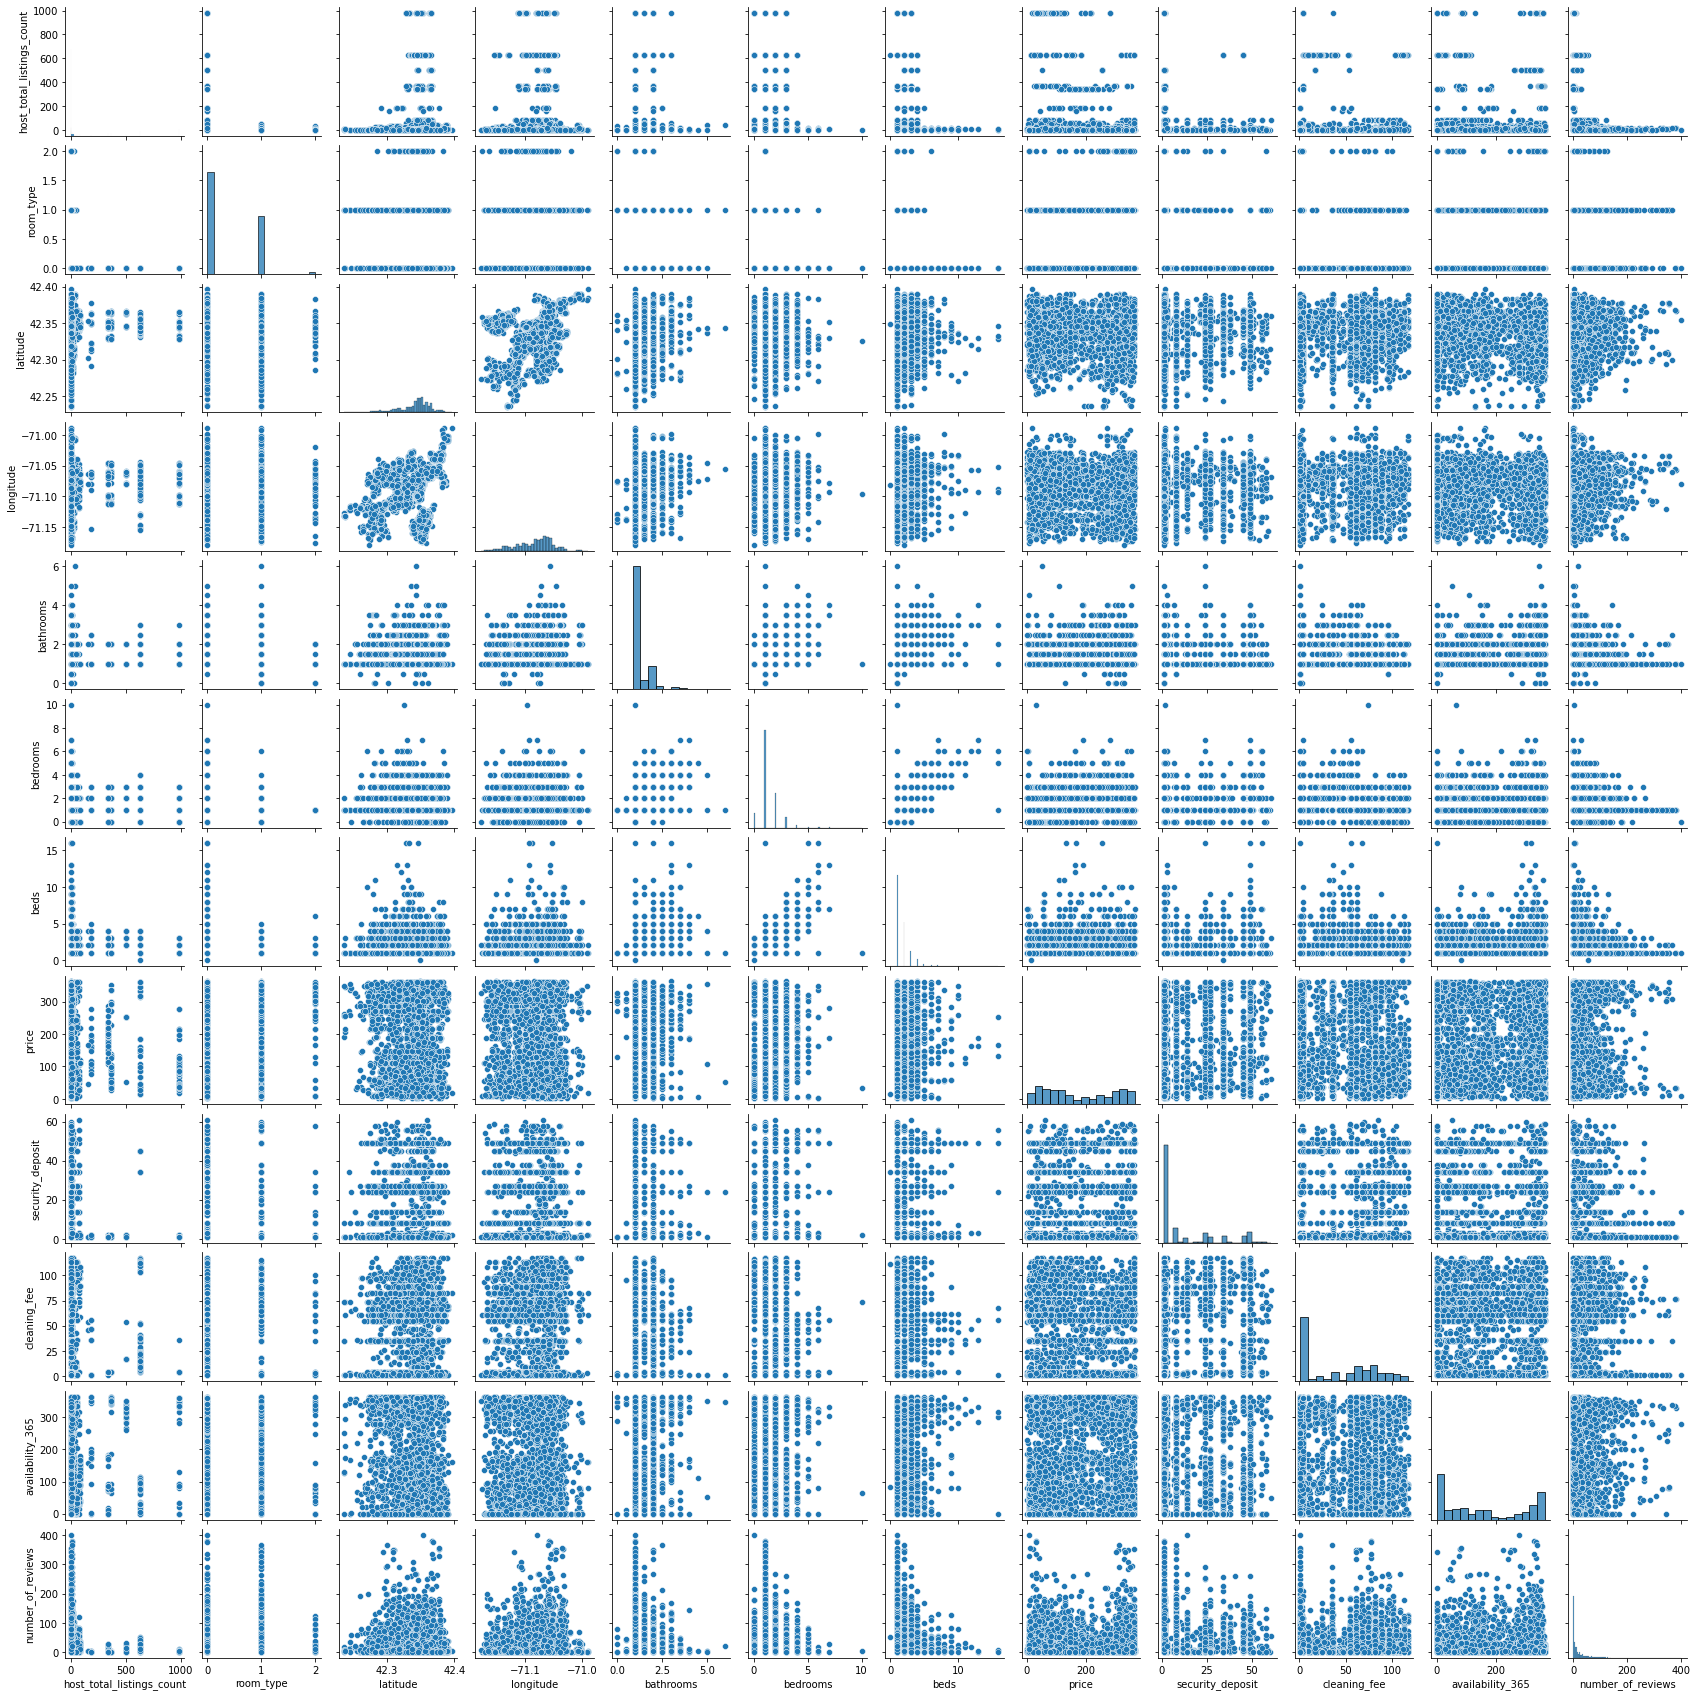

In [39]:
sns.pairplot(train_listing, palette='tab10', height=2, dropna=True)

Based on the pairplot above, I can't see any predictors that have a linear or non-linear relationship with the response variable.

**2.2** Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e. basis functions $x, x^2, x^3$ for each predictor $x$) for quantitative predictors.


#### Linear Regression

In [40]:
# your code here
lm = LinearRegression().fit(X, y)
r2_train = lm.score(X, y)
r2_test = lm.score(X_test, y_test)
print('Linear Regression:\n')
print('The R2 training score is ', r2_train)
print('The R2 testing score is ', r2_test)

Linear Regression:

The R2 training score is  0.2415879117109433
The R2 testing score is  0.1813422280236512


#### Regression with polynomial basis functions of degree 3

In [41]:
formula = 'price ~ np.vander(host_total_listings_count, 4) - 1 + room_type + np.vander(host_total_listings_count, 4) - 1 + np.vander(host_total_listings_count, 4) - 1 + np.vander(latitude, 4) - 1 + np.vander(longitude, 4) - 1 + np.vander(bathrooms, 4) - 1 + np.vander(bedrooms, 4) - 1 + np.vander(beds, 4) - 1 + np.vander(security_deposit, 4) - 1 + np.vander(cleaning_fee, 4) - 1 + np.vander(availability_365, 4) - 1 + np.vander(number_of_reviews, 4) - 1'
lm_d3_train = sm.ols(formula, data = train_listing).fit()
lm_d3_test = sm.ols(formula, data = test_listing).fit()
print('Polynomial Regression:\n')
print('The R2 training score is ',lm_d3_train.rsquared)
print('The R2 testing score is ',lm_d3_test.rsquared)

Polynomial Regression:

The R2 training score is  0.2632384825585917
The R2 testing score is  0.28601438288493064


The Polynomial Regression created with Vandermonde matrices yield better results on the training and the testing sets than the Linear Regression. Interestingly, the testing scores are better than the training scores, this must be due to the fact that we had a lucky split.

**2.3** Do you expect any advantage in fitting an additive model to these data, compared to the above models?


- Yes indeed, in the above models, we only considered **independent** relations between predictors and the target variables. An additive model would allow us to consider and take into account interactions between different variables instead of viewing them only separately.
- Moreover, in the previous models, we made some really strong assumptions: for the linear model, we imposed a hard parametric form on the expected answer. For the polynomial regression, we imposed a **global** polynomial structure on the expected answer. What we do with fitting additive models is that for every feature, we are fitting penalized B splines. The advantages of these penalized B splines is that they allow for more flexibility in the function. However, the flexibility in the function is not encoded in the degree of these functions (since we are working with **fixed** degree 3 functions) but rather in the number of knots. Also, the smoothness parameter allow us to reduce the effective number of degrees of freedom: this more general framework will allow to benefit from both the flexibility of local cubic polynomials and the smoothness imposed on the penalization

**2.4** Fit an additive model using the `pygam` library to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a penalized B-spline basis function on each predictor, tuned using cross-validation on the training set.


In [43]:
# This model will fit spline terms on features 0,2,3,7,8,9,10
# and factor terms on features 1,2,4,5,6
gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + f(4) + f(5) + f(6) + s(7) + s(8) + s(9) + s(10))
gam.gridsearch(X.values, y.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:12 Time:  0:00:12


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     53.4076
Link Function:                     IdentityLink Log Likelihood:                                -44111.5651
Number of Samples:                         4370 AIC:                                            88331.9455
                                                AICc:                                           88333.3429
                                                GCV:                                              9871.526
                                                Scale:                                           9654.6055
                                                Pseudo R-Squared:                                   0.2783
Feature Function                  Lam

<ipython-input-43-bcb943d4c651>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [44]:
train_r2 = r2_score(y, gam.predict(X))
test_r2= r2_score(y_test, gam.predict(X_test))
print('Additive model 1:\n')
print('The R2 training score is ', train_r2)
print('The R2 testing score is ', test_r2)


Additive model 1:

The R2 training score is  0.2782974309002204
The R2 testing score is  0.23166304529019455


The additive model yields the best $R^2$ out of the Linear Regression and the Polynomial Regression.

**2.5** Plot and examine the smooth of each predictor for the fitted additive model. What are some useful insights conveyed by these plots?


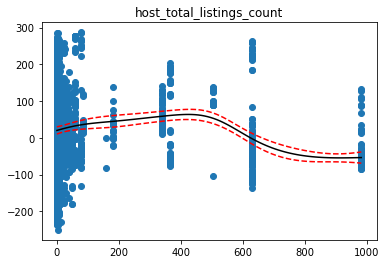

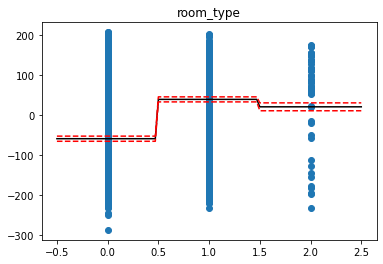

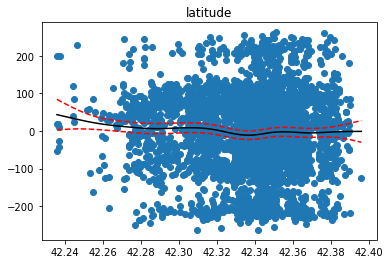

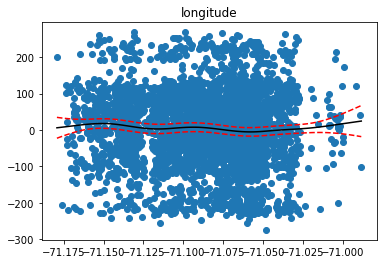

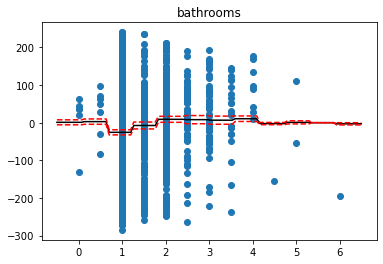

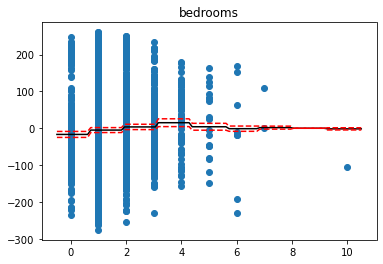

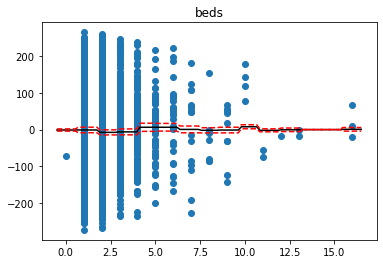

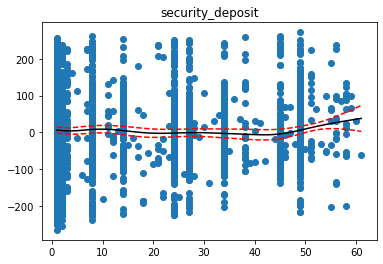

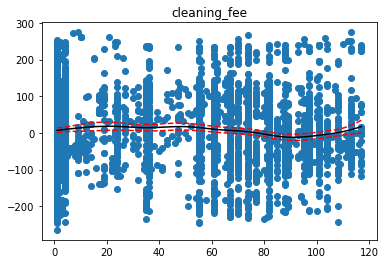

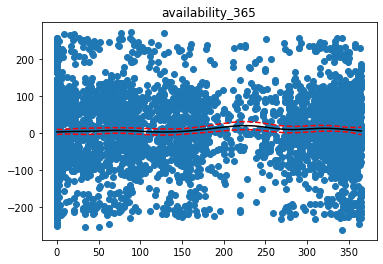

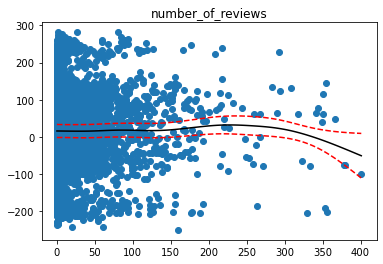

In [45]:
# your code here
res = gam.deviance_residuals(X,y)
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep, c='black')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

These plots depict the partial dependance of each predictor on the price, we are to examine each of their effects. As a reminder, spline terms were fitted on:
- host_total_listings_count	
- latitude	
- longitude		
- security_deposit	
- cleaning_fee	
- availability_365	
- number_of_reviews <br>
And factor terms on:
- room_type	
- bathrooms	
- bedrooms	
- beds

From these we can see a number of insightful trends:
* The number of beds, bathrooms and bedrooms do not weigh a lot on the trend, their numbers do not seem to influence the price
* Models fitted on the predictors latitude and longitude as well have an unpredictable behavior
* We can see that large security deposits the trend of the model suggests that the price increases
* Surprinsigly, the more reviews there is the lower the price is going to be
* The availability of the rental does not influence the price
* The most coveted types of rentals are entire appartment and shared room, compared to private rooms
* We also see that prediction intervals are extremely narrow for the features of the rental, namely, number of beds, bathhrooms and bedrooms

**2.6** Using the outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

*Your answer here*

From part 1) we have seen that the timeframe of the booking of a listing is heavily linked to its price. Bookings on weekends are more expensive and the season is also important: during Spring and Summer prices tend to be higher due to the hot weather. 

In part 2) we have just seen that the most 'influent' predictors were the number of reviews of the rental, its type, the number of reviews it has and the number of listings of the host.


In order to save money, one should consider coming to Boston during the week and preferably during Fall or Winter. It is also recommended to choose a private room, from a host with many listings and with many reviews